# Histograms of docking scores

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import sys
from pathlib import Path
from time import time
import numpy as np
import pandas as pd
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
print(Path.cwd())

/vol/ml/apartin/projects/covid-19/ML-docking-dataframe-generator/nbs


In [2]:
datadir = Path('../data/raw/dock-2020-06-01/OZD')
outfigs = Path('../data/raw/dock-2020-06-01/OZD-hist')
os.makedirs(outfigs, exist_ok=True)
files = sorted(datadir.glob('*4col.csv'))
len(files)

35

In [3]:
def save_hist(dd_trg, trg_name, score_name='reg'):
    dd_trg = dd_trg[ ~dd_trg[score_name].isna() ].reset_index(drop=True)
    dd_trg[score_name] = abs( np.clip(dd_trg[score_name], a_min=None, a_max=0) )

    q_cls=0.025
    cls_th = dd_trg[score_name].quantile(q=q_cls)

    bins = 50
    hist, bin_edges = np.histogram(dd_trg[score_name], bins=bins)
    x = np.ones((10,)) * cls_th
    y = np.linspace(0, hist.max(), len(x))

    fig, ax = plt.subplots()
    plt.hist(dd_trg[score_name], bins=bins, density=False, facecolor='b', alpha=0.5)
    plt.title(f'Scores Clipped to 0: {trg_name}');
    plt.ylabel('Count'); plt.xlabel('Docking Score');
    plt.plot(x, y, 'r--', alpha=0.7, label=f'{q_cls}-th quantile')
    plt.grid(True)
    plt.savefig(outfigs/f'dock.score.{trg_name}.png');

In [4]:
def cast_to_float(x, float_format=np.float64):
    try:
        x = np.float64(x)
    except:
        print("Could not cast the value to numeric: {}".format(x))
        x = np.nan
    return x

In [5]:
dock = pd.read_csv(files[0])
print(dock.shape)

(6109329, 4)


In [6]:
# fea_df = pd.read_parquet('/vol/ml/apartin/projects/covid-19/ML-docking-dataframe-generator/data/raw/features/fea-subsets-hpc/descriptors/dd_fea.parquet')
# print(fea_df.shape)

In [7]:
score_name = 'reg'
dock = dock.rename(columns={'Chemgauss4': score_name}) 
dock = dock[ ~dock[score_name].isna() ].reset_index(drop=True)
dock[score_name] = abs( np.clip(dock[score_name], a_min=None, a_max=0) )

# bins = 50
dock = dock.sort_values('reg', ascending=False).reset_index(drop=True)

In [8]:
n_samples = int(100e3)
# n_samples = int(1e6)
# n_samples = int(20e3)

n_top = int(10e3)
n_bot = n_samples - n_top

In [9]:
# dock = dock.sort_values('reg').reset_index(drop=True)
df_top  = dock[:n_top].reset_index(drop=True)
df_rest = dock[n_top:].reset_index(drop=True) # sorted, index reset

# df_bot = df_rest.sample(n=n_bot, random_state=10)
# dd = pd.concat([df_top, df_bot], axis=0).reset_index(drop=True)
print(df_top.shape)
print(df_rest.shape)
# print(df_bot.shape)
# print(dd.shape)

(10000, 4)
(6099328, 4)


In [10]:
# # method 1
# n_bins = 100
# bins = np.quantile(df_rest['reg'].values, np.linspace(0, 1, n_bins+1))
# df_rest['bins'] = pd.cut(df_rest['reg'].values, bins, precision=5, include_lowest=True)
# print(df_rest['bins'].nunique())

In [11]:
## method 2
# n_bins = 10000
# bins = [int(i) for i in np.linspace(0, df_rest.shape[0], n_bins+1)]
# df_rest['bins'] = pd.cut(df_rest.index.values, bins, precision=5, include_lowest=True)
# len(bins)

In [56]:
# method 3
n_bins = 100
bins = np.linspace(0, df_rest['reg'].max(), n_bins+1)
# print(len(np.unique(bins)))
# print( np.unique(bins[1:] - bins[:-1]) )
df_rest['bin'] = pd.cut(df_rest['reg'].values, bins, precision=5, include_lowest=True)
print(df_rest['bin'].nunique())

96


In [57]:
print(df_rest['bin'].unique()[:3])
# [b.right-b.left for b in df_rest['bin'].unique()]

[(11.65407, 11.77179], (11.53636, 11.65407], (11.41864, 11.53636]]
Categories (96, interval[float64]): [(-1e-05, 0.11772] < (0.11772, 0.23544] < (0.70631, 0.82403] < (0.82403, 0.94174] ... (11.30092, 11.41864] < (11.41864, 11.53636] < (11.53636, 11.65407] < (11.65407, 11.77179]]


In [59]:
# Create count for the bins and sort
df_rest['count'] = 1
ref = df_rest.groupby(['bin']).agg({'count': sum}).reset_index()
ref = ref.sort_values('count').reset_index(drop=True)
print(ref.shape)
display(ref[:4])

(100, 2)


,bin,count
0,"(0.23544, 0.35315]",0
1,"(0.35315, 0.47087]",0
2,"(0.47087, 0.58859]",0
3,"(0.58859, 0.70631]",0


In [ ]:
ref

In [60]:
n_bins = len(ref)
n_per_bin = int(n_bot/n_bins)
print('n_bot:    ', n_bot)
print('n_bins:   ', n_bins)
print('n_per_bin:', n_per_bin)

n_bot:     90000
n_bins:    100
n_per_bin: 900


In [65]:
n_bins_ = n_bins
n_bot_ = n_bot
n_per_bin_ = n_per_bin
del n_bins, n_bot, n_per_bin

indices = []
for r in range(ref.shape[0]):
# for r in range(12):    
    b = ref.loc[r,'bin']   # the bin interval
    c = ref.loc[r,'count'] # count in the bin
    if c==0:
        # print('Sec 1: row: {}, count: {}, bin: {}'.format(r, c, b))
        # print('   Empty bin!')
        n_bot_ = n_bot_ # same since we didn't collect samples
        n_bins_ = n_bins_ - 1 # less bins by 1
        n_per_bin_ = int(n_bot_/n_bins_) # update ratio
        # continue
    elif n_per_bin_ > c:
        # print('Sec 2: row: {}, count: {}, bin: {}'.format(r, c, b))
        idx = df_rest['bin']==b
        idx = df_rest.index.values[idx]
        indices.extend(idx) # collect all samples in this bin
        
        n_bot_ = n_bot_ - len(idx) # less samples left
        n_bins_ = n_bins_ - 1 # less bins by 1
        n_per_bin_ = int(n_bot_/n_bins_) # update ratio
    else:
        # print('Sec 3: row: {}, count: {}, bin: {}'.format(r, c, b))
        # print('   n_bot_:    ', n_bot_)
        # print('   n_bins_:   ', n_bins_)
        # print('   n_per_bin_:', n_per_bin_)
        idx = df_rest['bin']==b
        idx = df_rest.index.values[idx]
        indices.extend( np.random.choice(idx, size=n_per_bin_) ) # sample indices

df_bot = df_rest.loc[indices, :].reset_index(drop=True)        

In [66]:
# print('n_bot:    ', n_bot)
# print('n_bins:   ', n_bins)
# print('n_per_bin:', n_per_bin)

In [67]:
print('n_bot_:    ', n_bot_)
print('n_bins_:   ', n_bins_)
print('n_per_bin_:', n_per_bin_)

n_bot_:     84488
n_bins_:    57
n_per_bin_: 1482


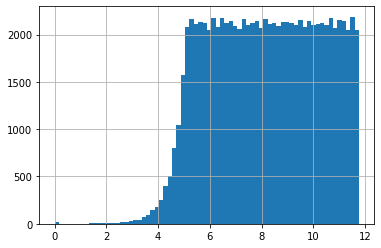

In [68]:
df_bot['reg'].hist(bins=70);

In [69]:
aa = pd.concat([df_top, df_bot], axis=0).reset_index(drop=True)
print(aa.shape)

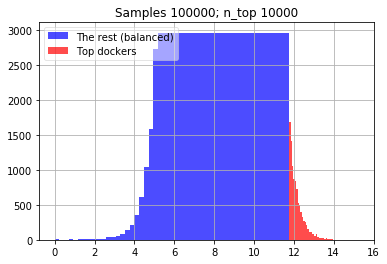

In [82]:
fig, ax = plt.subplots()
# ax.hist(df_bot[score_name], bins=50, facecolor='b', alpha=0.7);
# ax.hist(df_top[score_name], bins=50, facecolor='r', alpha=0.7);
ax.hist(df_bot[score_name], bins=50, facecolor='b', alpha=0.7, label='The rest (balanced)');
ax.hist(df_top[score_name], bins=50, facecolor='r', alpha=0.7, label='Top dockers');
plt.grid(True)
# plt.legend(frameon=False, shadow=False, loc='best', framealpha=0.5)
plt.legend(loc='best', framealpha=0.5)
plt.title(f'Samples {n_samples}; n_top {n_top}');